In [1]:
import numpy as np
import matplotlib.pyplot as plt
import matplotlib.cm
from scipy.stats import norm
from matplotlib.ticker import MultipleLocator, FormatStrFormatter


cm = plt.cm.get_cmap('Reds')
cm1 = plt.cm.get_cmap('Blues')
cm2  = plt.cm.get_cmap('Purples')

In [3]:
N = 16
n = 4 
x = np.linspace(-1,1,N)
y = np.linspace(-1,1,N)
xi,yi = np.meshgrid(x,y)
xi = xi + 0.075*np.random.uniform(0,1,(N,N))
yi = yi + 0.075*np.random.uniform(0,1,(N,N))

rho = 0.0
b = 16
lnkappa = np.random.randn(b,N,N)
lneta = np.random.randn(b,N,N)
lneta = rho*lnkappa + np.sqrt(1 - rho*rho)*lneta
lnkappa = -4*lnkappa
kappa = np.exp(lnkappa)

#lneta *= 0
eta = np.exp(lneta)

p = 0.5

def pattern(eta):
    return 1.0/(1.0 + (1.0/eta)**n)

def pattern_c(eta, kappa, c):
    return 1.0/(1.0 + ((1.0 + c/kappa)/(eta*c/kappa))**n)
    
def mixture(eta, kappa):
    kappa_sum = np.sum(1.0/kappa, axis = 0)
    etakappa_sum = np.sum(eta/kappa, axis = 0)
    eta_eff = etakappa_sum/kappa_sum
    return pattern(eta_eff)

def mixture_c(eta, kappa, c):
    kappa_sum = 1.0 + np.sum(c/kappa, axis = 0)
    etakappa_sum = np.sum(c*eta/kappa, axis = 0)
    return 1.0/(1.0 + (kappa_sum/etakappa_sum)**n)

def mono_response_m(K1,e1,n, Km1, nm, em):
    X1 = np.logspace(-4,4,80)
    e1 = e1*((1 - em*(1/(1 + Km1/X1)))**nm)
    return 1.0/(1.0 + ((1.0 + X1/K1)/(e1*X1/K1))**n)
def mono_response_m_c(X, K,e,M, Km, nm, em):
    em1 = em*(M/Km)/(1.0 + (M/Km))
    e = e*(1-em1)**nm
    return 1.0/(1.0 + ((1.0 + X/K)/(e*X/K))**n)

def mixture_response_m(X1, X2, K1, K2, e1, e2, Km1, em1, Km2, em2,nm):
    em = (em1*(X1/Km1) + em2*(X2/Km2))/(1 + (X1/Km1) + (X2/Km2))
    e1 = e1*(1 - em)**nm
    e2 = e2*(1 - em)**nm
    #print(em)
    return 1.0/(1.0 + ((1.0 + X1/K1 + X2/K2)/(e1*X1/K1 + e2*X2/K2))**n)

In [8]:
#Figure 4: Glomeruli with increasing concentration
plt.close("all")
fig,axis = plt.subplots(1,1,figsize = (6,6))

lnc = -2*np.log(10)*np.ones((b,N,N))
c = np.exp(lnc)

t = 1.0/(1.0+ np.exp(-n*norm.ppf(1 - p)))
circ = np.sqrt(xi**2 + yi**2) < 0.6
axis.scatter(xi[circ],yi[circ], c = (pattern_c(eta[0], kappa[0], c[0]) > t)[circ], edgecolors = 'k',linewidths = 2, s = 300, cmap = cm1 , vmin = 0.1, vmax =1, alpha = 1)
#axis.scatter(xi,yi, c = (mixture_c(eta,kappa,c) > t), cmap = cm , vmin = 0, vmax =1, alpha = 0.6)
plt.axis('off')
plt.tight_layout()
fig.savefig("fig4_glom_conc1e-3.eps", dpi = 200)

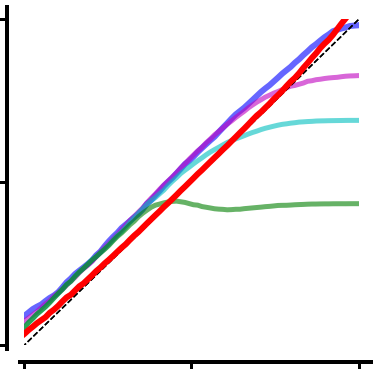

In [29]:
#Figure 4: Concentration coding
matplotlib.rcParams['font.family'] = "sans-serif"
matplotlib.rcParams['font.sans-serif'] = ['Tahoma']
plt.close("all")
fig,axis= plt.subplots(1,1,figsize = (6,6))

N = 16
n = 4 
x = np.linspace(-1,1,N)
y = np.linspace(-1,1,N)
xi,yi = np.meshgrid(x,y)
xi = xi + 0.075*np.random.uniform(0,1,(N,N))
yi = yi + 0.075*np.random.uniform(0,1,(N,N))


rho = 1.0
b = 100
lnkappa = np.random.randn(b,N,N)
lneta = np.random.randn(b,N,N)
lneta = rho*lnkappa + np.sqrt(1 - rho*rho)*lneta
lnkappa = -4*lnkappa
kappa = np.exp(lnkappa)
#lneta *= 0
eta = np.exp(lneta)

p = 0.5
numtrials = 100
lnc = np.linspace(-10*np.log(10),10*np.log(10),1000)
lc_pred = np.zeros(numtrials)
lc_pred_mix = np.zeros(numtrials)
lowerlc = -7*np.log(10)
upperlc = 3*np.log(10)
lc_plot = np.linspace(lowerlc, upperlc, numtrials)
for bs in range(b)[1:]:
    num = 0
    increments = []
    t = 1.0/(1.0+ np.exp(-n*norm.ppf(1 - p)))
    for i,lcs in enumerate(lnc[:]):
        if np.sum(pattern_c(eta[bs],kappa[bs],np.exp(lcs)) > t) > num:
            increments.append(lcs)
            num += 1
    increments = np.array(increments)
    increments[1:] = increments[1:] - increments[:-1] 
    activ = pattern_c(eta[bs],kappa[bs],np.exp(lnc[-1])) > t
    lc = np.random.uniform(lowerlc, upperlc, numtrials)
    lc  = lc_plot
    for i in range(numtrials):
        k = np.sum((pattern_c(eta[bs],kappa[bs],np.exp(lc[i])) > t)) 
        k_mix = np.sum((mixture_c(eta[bs-1:bs+1],kappa[bs-1:bs+1],np.exp(lc[i])) > t)[activ]) 
        lc_pred[i] += np.sum(increments[:(k+1)])
        lc_pred_mix[i] += np.sum(increments[:(k_mix+1)])
lc_pred /= b-1
lc_pred_mix /= b-1 
#axis.loglog(np.exp(lc_plot - np.median(lc_plot)),np.exp(lc_pred - np.median(lc_plot)), 'r-', markersize = 2, linewidth = 7)
axis.loglog(np.exp(lc_plot- np.median(lc_plot)),np.exp(lc_pred_mix- np.median(lc_plot)), 'b-',linewidth = 6, markersize = 3, alpha = 0.6)
axis.loglog(np.exp(np.linspace(lowerlc,upperlc,10) - np.median(lc_plot) ),np.exp(np.linspace(lowerlc,upperlc,10) - np.median(lc_plot)), 'k--')

rho = 0.5
lnkappa = np.random.randn(b,N,N)
lneta = np.random.randn(b,N,N)
lneta = rho*lnkappa + np.sqrt(1 - rho*rho)*lneta
lnkappa = -4*lnkappa
kappa = np.exp(lnkappa)
eta = np.exp(lneta)


numtrials = 100
lnc = np.linspace(-10*np.log(10),10*np.log(10),1000)
lc_pred = np.zeros(numtrials)
lc_pred_mix = np.zeros(numtrials)
lowerlc = -6*np.log(10)
upperlc = 4*np.log(10)
lc_plot = np.linspace(lowerlc, upperlc, numtrials)
for bs in range(b)[1:]:
    num = 0
    increments = []
    t = 1.0/(1.0+ np.exp(-n*norm.ppf(1 - p)))
    for i,lcs in enumerate(lnc[:]):
        if np.sum(pattern_c(eta[bs],kappa[bs],np.exp(lcs)) > t) > num:
            increments.append(lcs)
            num += 1
    increments = np.array(increments)
    increments[1:] = increments[1:] - increments[:-1] 
    activ = pattern_c(eta[bs],kappa[bs],np.exp(lnc[-1])) > t
    lc = np.random.uniform(lowerlc, upperlc, numtrials)
    lc  = lc_plot
    for i in range(numtrials):
        k = np.sum((pattern_c(eta[bs],kappa[bs],np.exp(lc[i])) > t)) 
        k_mix = np.sum((mixture_c(eta[bs-1:bs+1],kappa[bs-1:bs+1],np.exp(lc[i])) > t)[activ]) 
        lc_pred[i] += np.sum(increments[:(k+1)])
        lc_pred_mix[i] += np.sum(increments[:(k_mix+1)])
lc_pred /= b-1
lc_pred_mix /= b-1 
#axis.loglog(np.exp(lc_plot - np.median(lc_plot)),np.exp(lc_pred - np.median(lc_plot)), 'go-', markersize = 2)
axis.loglog(np.exp(lc_plot- np.median(lc_plot)),np.exp(lc_pred_mix- np.median(lc_plot)), 'm-', linewidth = 5, markersize = 5, alpha = 0.6)
axis.loglog(np.exp(np.linspace(lowerlc,upperlc,10) - np.median(lc_plot) ),np.exp(np.linspace(lowerlc,upperlc,10) - np.median(lc_plot)), 'k--')

um = 1

rho = 0.0
lnkappa = np.random.randn(b,N,N)
lneta = np.random.randn(b,N,N)
lneta = rho*lnkappa + np.sqrt(1 - rho*rho)*lneta
lnkappa = -4*lnkappa
kappa = np.exp(lnkappa)
eta = np.exp(lneta)


numtrials = 100
lnc = np.linspace(-10*np.log(10),10*np.log(10),1000)
lc_pred = np.zeros(numtrials)
lc_pred_mix = np.zeros(numtrials)
lc_pred_mask = np.zeros(numtrials)
lowerlc = -5*np.log(10)
upperlc = 5*np.log(10)
lc_plot = np.linspace(lowerlc, upperlc, numtrials)
for bs in range(b)[1:]:
    num = 0
    increments = []
    t = 1.0/(1.0+ np.exp(-n*norm.ppf(1 - p)))
    for i,lcs in enumerate(lnc[:]):
        if np.sum(pattern_c(eta[bs],kappa[bs],np.exp(lcs)) > t) > num:
            increments.append(lcs)
            num += 1
    increments = np.array(increments)
    increments[1:] = increments[1:] - increments[:-1] 
    activ = pattern_c(eta[bs],kappa[bs],np.exp(lnc[-1])) > t
    lc = np.random.uniform(lowerlc, upperlc, numtrials)
    lc  = lc_plot
    for i in range(numtrials):
        k = np.sum((pattern_c(eta[bs],kappa[bs],np.exp(lc[i])) > t)) 
        k_mask = np.sum((mixture_response_m(np.exp(lc[i]), np.exp(lc[i]), kappa[bs-1], kappa[bs], eta[bs-1], eta[bs], 1 , 0,  1e0 , um , 1) > t)[activ])
        k_mix = np.sum((mixture_c(eta[bs-1:bs+1],kappa[bs-1:bs+1],np.exp(lc[i])) > t)[activ]) 
        
        lc_pred[i] += np.sum(increments[:(k+1)])
        lc_pred_mix[i] += np.sum(increments[:(k_mix+1)])
        lc_pred_mask[i] += np.sum(increments[:(k_mask+1)])
lc_pred /= b-1
lc_pred_mix /= b-1 
lc_pred_mask /= b-1
axis.loglog(np.exp(lc_plot- np.median(lc_plot)),np.exp(lc_pred_mix- np.median(lc_plot)), 'c-', linewidth=5,markersize = 2, alpha = 0.6)
#axis.loglog(np.exp(np.linspace(lowerlc,upperlc,10) - np.median(lc_plot) ),np.exp(np.linspace(lowerlc,upperlc,10) - np.median(lc_plot)), 'k--', linewidth=6)
axis.loglog(np.exp(lc_plot- np.median(lc_plot)),np.exp(lc_pred_mask- np.median(lc_plot)), 'g-', linewidth=5,markersize = 2, alpha = 0.6)

axis.loglog(np.exp(lc_plot - np.median(lc_plot)),np.exp(lc_pred - np.median(lc_plot)), 'r-', markersize = 2, linewidth = 6)

axis.set_xlim(1e-4,1e4)
axis.set_ylim(1e-4,1e4)
axis.spines['top'].set_visible(False)
axis.spines['right'].set_visible(False)
axis.spines['left'].set_linewidth(4)
axis.spines['bottom'].set_linewidth(4)
axis.get_yaxis().set_ticklabels([])
axis.get_xaxis().set_ticklabels([])
axis.spines['left'].set_position(('axes', -0.05))
axis.spines['bottom'].set_position(('axes', -0.05))
axis.tick_params(which = 'major', length = 10,width = 3, direction = 'out' )
axis.tick_params(which = 'minor', length = 0, direction = 'out' )
axis.set_xticks([1e-4,1e0,1e4])
axis.set_yticks([1e-4,1e0,1e4])
axis.spines['left'].set_bounds(8e-5,2e4)
axis.spines['bottom'].set_bounds(8e-5,2e4)

#axis.set_xlabel("True concentration", fontsize = 18)
#axis.set_ylabel("Estimated concentration", fontsize = 18)
#fig.tight_layout()
fig.savefig("fig4_conc_coding.eps")
plt.show()

In [261]:
#Figure 4: Inset, Concentration coding, Average error
matplotlib.rcParams['font.family'] = "sans-serif"
matplotlib.rcParams['font.sans-serif'] = ['Tahoma']
N = 16
n = 4 
x = np.linspace(-1,1,N)
y = np.linspace(-1,1,N)
xi,yi = np.meshgrid(x,y)
xi = xi + 0.075*np.random.uniform(0,1,(N,N))
yi = yi + 0.075*np.random.uniform(0,1,(N,N))

rho = 0.0
b = 1000
lnkappa = np.random.randn(b,N,N)
lneta = np.random.randn(b,N,N)
lneta = rho*lnkappa + np.sqrt(1 - rho*rho)*lneta
lnkappa = -4*lnkappa
kappa = np.exp(lnkappa)

#lneta *= 0
eta = np.exp(lneta)

p = 0.25
numtrials = 100
error = np.zeros((b, numtrials))
lc = np.linspace(-2.5*np.log(10), 2.5*np.log(10), numtrials)
for bs in range(b):
    lnc = np.linspace(-6*np.log(10),6*np.log(10),500)
    num = 0
    increments = []
    t = 1.0/(1.0+ np.exp(-n*norm.ppf(1 - p)))
    for i,lcs in enumerate(lnc[:]):
        if np.sum(pattern_c(eta[bs],kappa[bs],np.exp(lcs)) > t) > num:
            increments.append(lcs)
            num += 1
    increments = np.array(increments)
    increments[1:] = increments[1:] - increments[:-1] 
    
    
    lc_pred = np.zeros(numtrials)
    for i in range(numtrials):
        k = np.sum(pattern_c(eta[bs],kappa[bs],np.exp(lc[i])) > t)        
        lc_pred[i] = np.sum(increments[:(k+1)])
        #error[bs][i] = np.mean(abs(np.exp(lc[i]) - np.exp(lc_pred[i]))/np.exp(lc[i]))
        error[bs][i] = np.mean(abs(lc[i] - lc_pred[i]))

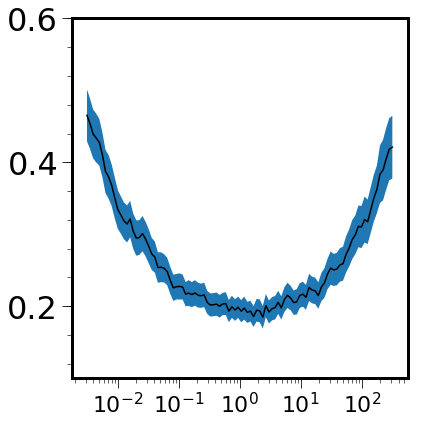

In [272]:
plt.close("all")
fig,axis = plt.subplots(1,1,figsize = (6,6))
axis.set_xscale("log")
axis.plot(np.exp(lc), np.mean(error,axis = 0), 'k-')
axis.fill_between(np.exp(lc), np.mean(error,axis = 0) -  3*np.std(error,axis=0)/np.sqrt(b), np.mean(error,axis = 0) +  3*np.std(error,axis=0)/np.sqrt(b))
axis.set_ylim(0.1,0.6)
axis.yaxis.set_minor_locator(MultipleLocator(0.04))
axis.yaxis.set_major_locator(MultipleLocator(0.2))
axis.tick_params(axis='x', which='major', labelsize=22)
axis.tick_params(axis='y', which='major', labelsize=32)
axis.spines['left'].set_linewidth(3)
axis.spines['right'].set_linewidth(3)
axis.spines['top'].set_linewidth(3)
axis.spines['bottom'].set_linewidth(3)
axis.tick_params(which = 'major',length = 10)
axis.tick_params(which = 'minor',length = 5)
#axis.set_ylabel(r"$|\Delta \ln c|$", fontsize = 18)
fig.tight_layout()
fig.savefig("fig4_conc_coding_inset.eps")
plt.show()

In [389]:
#Figure 4: Concentration coding of mixtures with fixed A and varying B
#NOT BEING USED AT THE MOMENT
matplotlib.rcParams['font.family'] = "sans-serif"
matplotlib.rcParams['font.sans-serif'] = ['Tahoma']
plt.close("all")
fig,axis= plt.subplots(1,1,figsize = (6,6))

N = 16
n = 4 
x = np.linspace(-1,1,N)
y = np.linspace(-1,1,N)
xi,yi = np.meshgrid(x,y)
xi = xi + 0.075*np.random.uniform(0,1,(N,N))
yi = yi + 0.075*np.random.uniform(0,1,(N,N))


rho = 0.0
b = 100
lnkappa = np.random.randn(b,N,N)
lneta = np.random.randn(b,N,N)
lneta = rho*lnkappa + np.sqrt(1 - rho*rho)*lneta
lnkappa = -4*lnkappa
kappa = np.exp(lnkappa)
#lneta *= 0
eta = np.exp(lneta)

p = 0.5
numtrials = 100
lnc = np.linspace(-10*np.log(10),10*np.log(10),1000)
lc_pred = np.zeros(numtrials)
lc_pred_mix = np.zeros(numtrials)
lowerlc = -5*np.log(10)
upperlc = 5*np.log(10)
lc_plot = np.linspace(lowerlc, upperlc, numtrials)
lc_A = 0*np.log(10)
for bs in range(b)[1:]:
    num = 0
    increments = []
    t = 1.0/(1.0+ np.exp(-n*norm.ppf(1 - p)))
    for i,lcs in enumerate(lnc[:]):
        if np.sum(pattern_c(eta[bs],kappa[bs],np.exp(lcs)) > t) > num:
            increments.append(lcs)
            num += 1
    increments = np.array(increments)
    increments[1:] = increments[1:] - increments[:-1] 
    activ = pattern_c(eta[bs],kappa[bs],np.exp(lnc[-1])) > t
    lc = np.random.uniform(lowerlc, upperlc, numtrials)
    lc  = lc_plot
    for i in range(numtrials):
        k = np.sum((pattern_c(eta[bs],kappa[bs],np.exp(lc_A)) > t)) 
        lc_AB = np.ones((2,N,N))
        lc_AB[0,:,:] = lc[i] 
        lc_AB[1,:,:] = lc_A
        k_mix = np.sum((mixture_c(eta[bs-1:bs+1],kappa[bs-1:bs+1],np.exp(lc_AB)) > t)[activ]) 
        lc_pred[i] += np.sum(increments[:(k+1)])
        lc_pred_mix[i] += np.sum(increments[:(k_mix+1)])
lc_pred /= b-1
lc_pred_mix /= b-1 
#axis.loglog(np.exp(lc_plot - np.median(lc_plot)),np.exp(lc_pred - np.median(lc_plot)), 'r-', markersize = 2, linewidth = 7)
axis.loglog(np.exp(lc_plot- np.median(lc_plot)),np.exp(lc_pred_mix- np.median(lc_plot)), 'b--',linewidth = 4, markersize = 3, alpha = 0.6)
axis.loglog(np.exp(np.linspace(lowerlc,upperlc,10) - np.median(lc_plot) ),np.exp(np.linspace(lowerlc,upperlc,10) - np.median(lc_plot)), 'k--')
axis.set_xlim(1e-5,1e5)
axis.set_ylim(1e-5,1e5)
axis.tick_params(axis='both', which='major', labelsize=18)
axis.spines['left'].set_linewidth(2)
axis.spines['right'].set_linewidth(2)
axis.spines['top'].set_linewidth(2)
axis.spines['bottom'].set_linewidth(2)
#axis.set_xlabel("True concentration", fontsize = 18)
#axis.set_ylabel("Estimated concentration", fontsize = 18)
fig.tight_layout()
fig.savefig("fig4_conc_coding_fixedA.eps")

In [19]:
#Figure 4: Reciprocal and non-reciprocal suppression
matplotlib.rcParams['font.family'] = "sans-serif"
matplotlib.rcParams['font.sans-serif'] = ['Tahoma']
plt.close("all")
fig,axis = plt.subplots(1,1,figsize = (6,6))

N = 16
n = 4
b = 500 #0
p = 0.5
t = 1.0/(1.0+ np.exp(-n*norm.ppf(1 - p)))


rho = 0.0
lnkappa = np.random.randn(b,N,N)
lneta = np.random.randn(b,N,N)
lneta = rho*lnkappa + np.sqrt(1 - rho*rho)*lneta
lnkappa = -4*lnkappa
kappa = np.exp(lnkappa)
#lneta *= 0
eta = np.exp(lneta)
numc = 50
lc1_r = np.linspace(2*np.log(10), 15*np.log(10), numc)
lc2_r = np.linspace(2*np.log(10), 15*np.log(10), numc)
lc1i, lc2i = np.meshgrid(lc1_r,lc2_r)

synergy = np.zeros((numc,numc))
inhibition = np.zeros((numc,numc))
supp1by2 = np.zeros((numc,numc))
supp2by1 = np.zeros((numc,numc))
mask1by2 = np.zeros((numc,numc))
um = 1.0
sc = 25
for i in range(numc):
    for j in range(numc):
        if j != sc:
            continue
        lc1 = lc1_r[i]
        lc2 = lc2_r[j]
        lc_12 = np.ones((2,N,N))
        lc_12[0,:,:] = lc1 
        lc_12[1,:,:] = lc2
        for bs in range(b)[1:]:
            pat1 = pattern_c(eta[bs-1],kappa[bs-1],np.exp(lc1)) > t
            pat2 = pattern_c(eta[bs],kappa[bs],np.exp(lc2)) > t

            mix12 = mixture_c(eta[bs-1:bs+1], kappa[bs-1:bs+1], np.exp(lc_12)) > t
            mask12 = mixture_response_m(np.exp(lc1), np.exp(lc2), kappa[bs-1], kappa[bs], eta[bs-1], eta[bs], 1 , 0,  1e0 , um , 1) > t
            synergy_b = (1 - pat1)*(1-pat2)*mix12
            inhibition_b = pat1*pat2*(1-mix12)
            
            supp1by2_b = pat1*(1-pat2)*(1-mix12)
            supp2by1_b = pat2*(1-pat1)*(1-mix12)
            
            mask1by2_b = pat1*(1-pat2)*(1-mask12)
            
            supp1by2[i][j] += np.sum(supp1by2_b)/np.sum(pat1)
            supp2by1[i][j] += np.sum(supp2by1_b)/np.sum(pat2)
            mask1by2[i][j] += np.sum(mask1by2_b)/np.sum(pat1)
            
        supp1by2[i][j] /= b-1
        mask1by2[i][j] /= b-1
        supp2by1[i][j] /= b-1
axis.semilogx(np.exp(lc1_r - lc2_r[sc]), mask1by2[:,sc], 'r-', linewidth = 5)

axis.semilogx(np.exp(lc1_r - lc2_r[sc]), supp1by2[:,sc], 'g-', linewidth = 7)
axis.semilogx(np.exp(lc1_r - lc2_r[sc]), supp2by1[:,sc], 'y-', linewidth = 7)



rho = 1.0
lnkappa = np.random.randn(b,N,N)
lneta = np.random.randn(b,N,N)
lneta = rho*lnkappa + np.sqrt(1 - rho*rho)*lneta
lnkappa = -4*lnkappa
kappa = np.exp(lnkappa)
#lneta *= 0
eta = np.exp(lneta)
numc = 50
lc1_r = np.linspace(0*np.log(10), 13*np.log(10), numc)
lc2_r = np.linspace(0*np.log(10), 13*np.log(10), numc)
lc1i, lc2i = np.meshgrid(lc1_r,lc2_r)

synergy = np.zeros((numc,numc))
inhibition = np.zeros((numc,numc))
supp1by2 = np.zeros((numc,numc))
supp2by1 = np.zeros((numc,numc))
sc = 25
for i in range(numc):
    for j in range(numc):
        if j != sc:
            continue
        lc1 = lc1_r[i]
        lc2 = lc2_r[j]
        lc_12 = np.ones((2,N,N))
        lc_12[0,:,:] = lc1 
        lc_12[1,:,:] = lc2
        for bs in range(b)[1:]:
            pat1 = pattern_c(eta[bs-1],kappa[bs-1],np.exp(lc1)) > t
            pat2 = pattern_c(eta[bs],kappa[bs],np.exp(lc2)) > t

            mix12 = mixture_c(eta[bs-1:bs+1], kappa[bs-1:bs+1], np.exp(lc_12)) > t
            synergy_b = (1 - pat1)*(1-pat2)*mix12
            inhibition_b = pat1*pat2*(1-mix12)
            supp1by2_b = pat1*(1-pat2)*(1-mix12)
            supp2by1_b = pat2*(1-pat1)*(1-mix12)
            supp1by2[i][j] += np.sum(supp1by2_b)/np.sum(pat1)
            supp2by1[i][j] += np.sum(supp2by1_b)/np.sum(pat2)
        supp1by2[i][j] /= b-1
        supp2by1[i][j] /= b-1

axis.semilogx(np.exp(lc1_r - lc2_r[sc]), supp1by2[:,sc], 'g--', linewidth = 7)
axis.semilogx(np.exp(lc1_r - lc2_r[sc]), supp2by1[:,sc], 'y--', linewidth = 7)

axis.set_ylim(-0.03,0.52)  
axis.set_xlim(1e-6,1e6)

axis.spines['top'].set_visible(False)
axis.spines['right'].set_visible(False)
axis.spines['left'].set_linewidth(4)
axis.spines['bottom'].set_linewidth(4)
axis.get_yaxis().set_ticklabels([])
axis.get_xaxis().set_ticklabels([])
axis.spines['left'].set_position(('axes', -0.05))
axis.spines['bottom'].set_position(('axes', -0.05))
axis.tick_params(which = 'major', length = 10,width = 3, direction = 'out' )
axis.tick_params(which = 'minor', length = 0, direction = 'out' )
axis.set_xticks([1e-6,1e-3,1e0,1e3,1e6])
axis.spines['left'].set_bounds(0,0.55)
axis.spines['bottom'].set_bounds(1e-6,1e6)
axis.yaxis.set_minor_locator(MultipleLocator(0.02))
axis.yaxis.set_major_locator(MultipleLocator(0.25))
#fig.tight_layout()
        
fig.savefig("fig4_mixture_supp.eps")        
#print(np.sum(synergy), np.sum(inhibition), np.sum(supp1by2)/np.sum(pat1), np.sum(supp2by1)/np.sum(pat2))
#print(np.sum(pat1)/N**2, np.sum(pat2)/N**2)
    

pat1

In [20]:
#Figure 4: Reciprocal and non-reciprocal suppression glomerulus 
matplotlib.rcParams['font.family'] = "sans-serif"
matplotlib.rcParams['font.sans-serif'] = ['Tahoma']
N = 16
n = 4
x = np.linspace(-1,1,N)
y = np.linspace(-1,1,N)
xi,yi = np.meshgrid(x,y)
xi = xi + 0.05*np.random.uniform(0,1,(N,N))
yi = yi + 0.05*np.random.uniform(0,1,(N,N))

b = 2
p = 0.5
t = 1.0/(1.0+ np.exp(-n*norm.ppf(1 - p)))


rho = 0.0
lnkappa = np.random.randn(b,N,N)
lneta = np.random.randn(b,N,N)
lneta = rho*lnkappa + np.sqrt(1 - rho*rho)*lneta
lnkappa = -4*lnkappa
kappa = np.exp(lnkappa)
#lneta *= 0
eta = np.exp(lneta)
numc = 50
lc1_r = np.linspace(2*np.log(10), 15*np.log(10), numc)
lc2_r = np.linspace(2*np.log(10), 15*np.log(10), numc)
lc1i, lc2i = np.meshgrid(lc1_r,lc2_r)

1.0


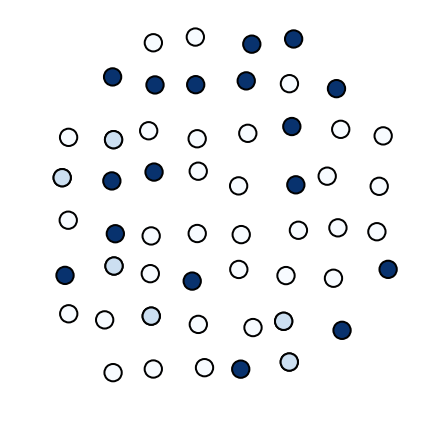

In [23]:
#Figure 4: Reciprocal and non-reciprocal suppression glomerulus 

i = 25
j = 25
plt.close("all")
fig,axis = plt.subplots(1,1,figsize = (6,6))
lc1 = lc1_r[i]
lc2 = lc2_r[j]
lc_12 = np.ones((2,N,N))
lc_12[0,:,:] = lc1 
lc_12[1,:,:] = lc2
pat1 = pattern_c(eta[0],kappa[0],np.exp(lc1)) > t
pat2 = pattern_c(eta[1],kappa[1],np.exp(lc2)) > t
mix12 = mixture_c(eta[0:2], kappa[0:2], np.exp(lc_12)) > t
supp2by1 = pat2*(1-pat1)*(1-mix12)
circ = (xi**2 + yi**2 < 0.3)
circsupp2 = circ*pat2*(~mix12)
circsupp1 = circ*pat1*(~mix12)

circadd2 = circ*(pat2)*(mix12)
circadd1 = circ*(pat1)*(mix12)
axis.scatter(xi[circ],yi[circ], c = 0.99*pat2[circ], edgecolors = 'k',linewidths = 2, s = 300, cmap = cm1 , vmin = 0.1, vmax =1, alpha = 1)
#axis.scatter(xi[circ],yi[circ], c = 1.0*mix12[circ], edgecolors = 'k',linewidths = 2, s = 300, cmap = cm1 , vmin = 0.0, vmax =1, alpha = 1)
axis.scatter(xi[circsupp2],yi[circsupp2], c = 0.3*np.ones((N,N))[circsupp2], edgecolors = 'k',linewidths = 2, s = 300, cmap = cm1 , vmin = 0.1, vmax =1, alpha = 1)
#axis.scatter(xi[circsupp1],yi[circsupp1], c = 0.3*np.ones((N,N))[circsupp1], edgecolors = 'k',linewidths = 2, s = 300, cmap = cm , vmin = 0.1, vmax =1, alpha = 1)

#axis.scatter(xi[circadd2],yi[circadd2], c = np.ones((N,N))[circadd2], edgecolors = 'k',linewidths = 2, s = 300, cmap = cm1 , vmin = 0.1, vmax =1, alpha = 1)
#axis.scatter(xi[circadd1],yi[circadd1], c = np.ones((N,N))[circadd1], edgecolors = 'k',linewidths = 2, s = 300, cmap = cm , vmin = 0.1, vmax =1, alpha = 1)
print(np.exp(lc1 - lc2))
plt.axis('off')
fig.tight_layout()
plt.show()
fig.savefig("fig4_mixsupp_glom_i1.eps" )
        



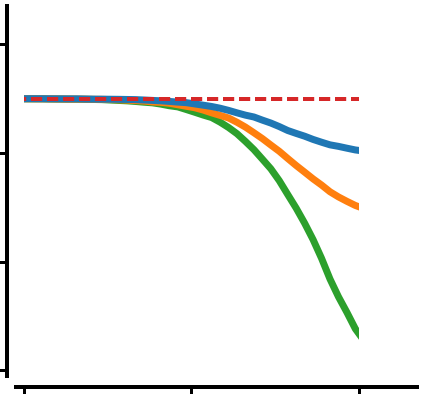

In [23]:
#Figure 4: Effect of masking on inferred concentration
matplotlib.rcParams['font.family'] = "sans-serif"
matplotlib.rcParams['font.sans-serif'] = ['Tahoma']
def supp_ratio_fitting(M,e1,n, Km, em1, nm1) :
    e2 = e1*((1 - em1*(1/(1 + Km/M)))**nm1)
    FM = (1.0 + np.exp(-n*np.log(e1)))/(1.0 + np.exp(-n*np.log(e2)))
    return 1.0 - FM

plt.close("all")
fig,axis= plt.subplots(1,1,figsize = (6,6))

N = 16
n = 4 
x = np.linspace(-1,1,N)
y = np.linspace(-1,1,N)
xi,yi = np.meshgrid(x,y)
xi = xi + 0.075*np.random.uniform(0,1,(N,N))
yi = yi + 0.075*np.random.uniform(0,1,(N,N))


rho = 0.0
b = 100
lnkappa = np.random.randn(b,N,N)
lneta = np.random.randn(b,N,N)
lneta = rho*lnkappa + np.sqrt(1 - rho*rho)*lneta
lnkappa = -4*lnkappa
kappa = np.exp(lnkappa)
#lneta *= 0
eta = np.exp(lneta)
um1 = 1.0
um2 = 0.7
um3 = 0.4
p = 0.5
numtrials = 100
lnc = np.linspace(-10*np.log(10),10*np.log(10),1000)
lc_pred = np.zeros(numtrials)
lc_pred_mix = np.zeros(numtrials)
lc_pred_mask1 = np.zeros(numtrials)
lc_pred_mask2 = np.zeros(numtrials)
lc_pred_mask3 = np.zeros(numtrials)
lowerlc = -5*np.log(10)
upperlc = 5*np.log(10)
lc_plot = np.linspace(lowerlc, upperlc, numtrials)
for bs in range(b)[1:]:
    num = 0
    increments = []
    t = 1.0/(1.0+ np.exp(-n*norm.ppf(1 - p)))
    for i,lcs in enumerate(lnc[:]):
        if np.sum(pattern_c(eta[bs],kappa[bs],np.exp(lcs)) > t) > num:
            increments.append(lcs)
            num += 1
    increments = np.array(increments)
    increments[1:] = increments[1:] - increments[:-1] 
    activ = pattern_c(eta[bs],kappa[bs],np.exp(lnc[-1])) > t
    lc = np.random.uniform(lowerlc, upperlc, numtrials)
    lc  = lc_plot
    for i in range(numtrials):
        pat1 = pattern_c(eta[bs],kappa[bs],1) > t
        mask1by2_1 = (mono_response_m_c(1, kappa[bs], eta[bs], np.exp(lc[i]), 1e0, 1, um1) > t)[activ]
        mask1by2_2 = (mono_response_m_c(1, kappa[bs], eta[bs], np.exp(lc[i]), 1e0, 1, um2) > t)[activ]
        mask1by2_3 = (mono_response_m_c(1, kappa[bs], eta[bs], np.exp(lc[i]), 1e0, 1, um3) > t)[activ]
        k = np.sum((pat1)) 
        k_mask_1 = np.sum(mask1by2_1)
        k_mask_2 = np.sum(mask1by2_2)
        k_mask_3 = np.sum(mask1by2_3)
        lc_pred[i] += np.sum(increments[:(k+1)])
        lc_pred_mask1[i] += np.sum(increments[:(k_mask_1+1)])
        lc_pred_mask2[i] += np.sum(increments[:(k_mask_2+1)])
        lc_pred_mask3[i] += np.sum(increments[:(k_mask_3+1)])
        
lc_pred_mask1 /= b-1
lc_pred_mask2 /= b-1
lc_pred_mask3 /= b-1
lc_pred /= b-1 
lc_pred_mix /= b-1

axis.loglog(np.exp(lc_plot), np.exp(-lc_pred + lc_pred_mask1), 'C2-', linewidth = 7)
axis.loglog(np.exp(lc_plot), np.exp(-lc_pred + lc_pred_mask2), 'C1-', linewidth = 7)
axis.loglog(np.exp(lc_plot), np.exp(-lc_pred + lc_pred_mask3), 'C0-', linewidth = 7)
axis.loglog(np.exp(lc_plot), np.ones(len(lc_plot)), 'C3--', linewidth = 4)
axis.spines['top'].set_visible(False)
axis.spines['right'].set_visible(False)
axis.spines['left'].set_linewidth(4)
axis.spines['bottom'].set_linewidth(4)
axis.get_yaxis().set_ticklabels([])
axis.get_xaxis().set_ticklabels([])
axis.spines['left'].set_position(('axes', -0.05))
axis.spines['bottom'].set_position(('axes', -0.05))
axis.tick_params(which = 'major', length = 10,width = 3, direction = 'out' )
axis.tick_params(which = 'minor', length = 0, direction = 'out' )
axis.set_xticks([1e-3,1e-1,1e1])
axis.set_yticks([1e-5,1e-3,1e-1,1e1])
axis.spines['left'].set_bounds(8e-6,5e1)
axis.spines['bottom'].set_bounds(8e-4,5e1)
axis.set_xlim(1e-3,1e1)
#fig.tight_layout()
fig.savefig("fig4_conc_coding_mask.eps")
plt.show()

In [209]:
#Figure 4: Blendedness
matplotlib.rcParams['font.family'] = "sans-serif"
matplotlib.rcParams['font.sans-serif'] = ['Tahoma']
N = 16
n = 4
x = np.linspace(-1,1,N)
y = np.linspace(-1,1,N)
xi,yi = np.meshgrid(x,y)
xi = xi + 0.05*np.random.uniform(0,1,(N,N))
yi = yi + 0.05*np.random.uniform(0,1,(N,N))

b = 5000
p = 0.3
t = 1.0/(1.0+ np.exp(-n*norm.ppf(1 - p)))
nmix = 20

rho = 0.0
lnkappa = np.random.randn(b,N,N)
lneta = np.random.randn(b,N,N)
lneta = rho*lnkappa + np.sqrt(1 - rho*rho)*lneta
lnkappa = -4*lnkappa
kappa = np.exp(lnkappa)
#lneta *= 0
eta = np.exp(lneta)
mix = mixture(eta,kappa) > t 
jacc = 0
smd = 0
for bs in range(b):
    pat = pattern(eta[bs]) > t
    mixodors = np.random.choice(np.arange(b, dtype = int), nmix - 1, replace= False)
    mixodors = np.append(mixodors, bs)
    mix =  mixture(eta[mixodors],kappa[mixodors]) > t 
    jacc += 1.0 - np.sum(pat*mix)/np.sum(pat + mix)
    smd += 1.0 - (np.mean(pat*mix) + np.mean((1-pat)*(1-mix)))
jacc /= b
smd /= b
print(jacc, smd)

0.762804506932 0.380115625


In [136]:
np.random.choice([1,3,4],2, replace = False)

array([3, 4])

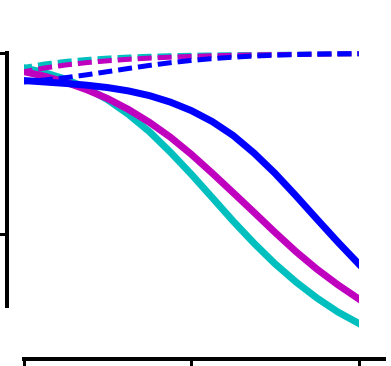

In [22]:
#Figure 4: Overshadowing
matplotlib.rcParams['font.family'] = "sans-serif"
matplotlib.rcParams['font.sans-serif'] = ['Tahoma']
x = np.arange(-4,4.1,0.25)
data1 = np.zeros((3,len(x)))
data2 = np.zeros((3,len(x)))
rho = [0.0, 0.5, 1.0]
for i in range(3):
    for j in range(len(x)):
        data1[i][j] = np.mean(np.loadtxt("./Numerics/overshadow_p0.5_rho%.1f_cratio%.2f.dat" %(rho[i],x[j]), skiprows = 1, usecols = (0)))
        data2[i][j] = np.mean(np.loadtxt("./Numerics/overshadow_p0.5_rho%.1f_cratio%.2f.dat" %(rho[i],x[j]), skiprows = 1, usecols = (1)))

plt.close("all")
fig,axis = plt.subplots(1,1,figsize = (6,6))
axis.semilogx(np.exp(x*np.log(10)), data1[0], 'c-', linewidth = 7 )
axis.semilogx(np.exp(x*np.log(10)), data1[1], 'm-', linewidth = 7)
axis.semilogx(np.exp(x*np.log(10)), data1[2], 'b-', linewidth = 7)

axis.semilogx(np.exp(x*np.log(10)), data2[0], 'c--', linewidth = 5)
axis.semilogx(np.exp(x*np.log(10)), data2[1], 'm--', linewidth = 5)
axis.semilogx(np.exp(x*np.log(10)), data2[2], 'b--', linewidth = 5)

#axis.semilogx([1,1e4], [0.5,0.5], '--', color = 'orange', linewidth = 3)
axis.spines['top'].set_visible(False)
axis.spines['right'].set_visible(False)
axis.spines['left'].set_linewidth(4)
axis.spines['bottom'].set_linewidth(4)
axis.get_yaxis().set_ticklabels([])
axis.get_xaxis().set_ticklabels([])
axis.spines['left'].set_position(('axes', -0.05))
axis.spines['bottom'].set_position(('axes', -0.05))
axis.tick_params(which = 'major', length = 10,width = 3, direction = 'out' )
axis.tick_params(which = 'minor', length = 0, direction = 'out' )
axis.set_xticks([1e0,1e2,1e4])
axis.spines['left'].set_bounds(0.3,1)
axis.spines['bottom'].set_bounds(1e0,2e4)

axis.yaxis.set_major_locator(MultipleLocator(0.5))
axis.set_xlim(1,1e4)
axis.set_ylim(0.2,1.1)
#fig.tight_layout()
fig.savefig("fig4_conc_coding_overshadow.eps")
plt.show()